# Gradient Boosting Machines (GBMs)

Gradient boosting machines é uma família de algoritmos de machine learning que, como as RandomForests (parentes distantes), utiliza um grupo de preditores fracos parar gerar um grande modelo mais forte. Usualmente esses modelos mais fracos são simples DecisionTrees e, normalmente, as GBM's geram resultados tão satisfatórios que são as queridinhas das competições do Kaggle e hackathons pelo país.

Mas o que são GBMs e como funcionam? Vamos responder essa perguntas nesse tutorial e, se tudo der certo, ao final você vai entender a lógica por trás de outros algoritmos que também utlizam estratégias parecidas.

## Importações

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [2]:
def get_sub(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s))
    return x.translate(res)

## Dados

In [3]:
df = pd.read_csv('../data/regression_data_2.csv',usecols=['x','y'])
df.x = df.x.apply(round,ndigits=2)
df.y = df.y.apply(round,ndigits=2)
df.head()

,x,y
0,84.40,36.82
1,36.75,18.46
2,23.25,29.44
3,45.29,15.09
4,95.85,49.05


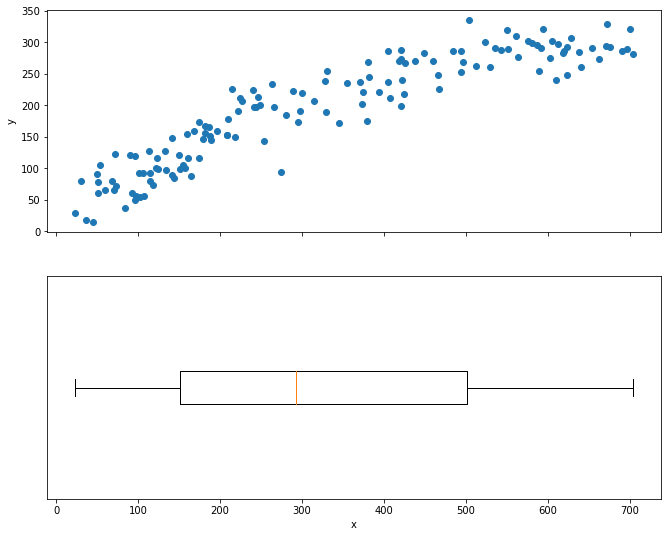

In [4]:
x,y = df.x,df.y

f, ax = plt.subplots(2,1,figsize=(11,9),sharex=True)

ax[0].scatter(x,y)
ax[0].set_ylabel('y')

ax[1].boxplot(x,vert=False)
ax[1].set_xlabel('x')
ax[1].set_yticks([])

plt.show()

## Intuição

No exemplo abaixo nosso trabalho é prever valores de $y$ utilizando a variável $x$ e para isso precisamos aprender uma função $F(x)$. Mas vamos começar do início! Utilizando os dados já carregados, vamos começar da forma mais intuitiva e simples o possível ... a média!

Vamos criar uma função $F_{0}$ que, para todo $x$, sempre prevê $\bar{y}$. Essa função fica mais um menos assim:

$F_{0}(x) = \bar{y} $

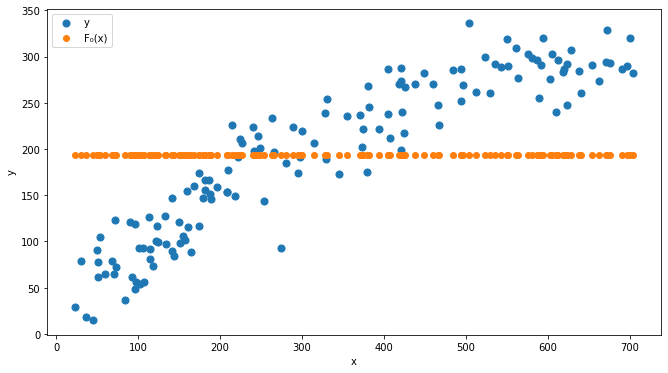

In [43]:
f, ax = plt.subplots(1,1,figsize=(11,6),sharex=True)
df.plot.scatter(x='x',y='y',ax=ax,s=50,label='y')
ax.scatter(df.x,[df.y.mean() for _ in range(len(df.x))],c='tab:orange',label='F{}(x)'.format(get_sub('0')))
plt.legend();

Os resultados acima são claramente questionáveis e podemos ver avaliar esse resultado utilizando um gráfico de resíduos.

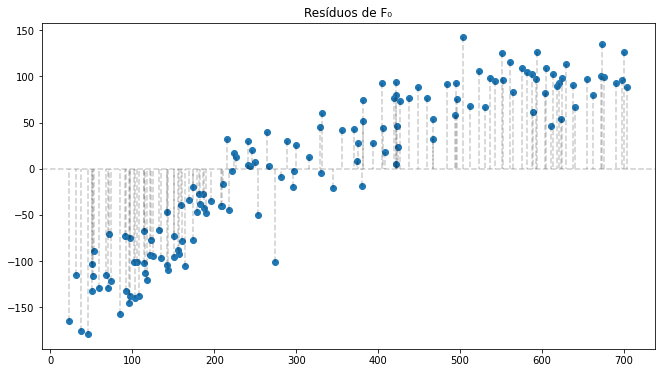

In [44]:
f, ax = plt.subplots(1,1,figsize=(11,6),sharex=True)

media = df.y.mean()

residuos = [y-media for y in df.y]

ax.scatter(df.x,residuos) ## dispersão dos resíduos
ax.axhline(0,c='black',ls='--',alpha=0.2) ## linha zero
ax.vlines(df.x,residuos,0,color='black',ls='--',alpha=0.2) ## linhas resíduos
ax.set_title('Resíduos de F{}'.format(get_sub('0')));

Vamos atualizar nosso dataframe para termos uma visão melhor das predições e dos resíduos!

In [9]:
df.head()

,x,y
0,84.40,36.82
1,36.75,18.46
2,23.25,29.44
3,45.29,15.09
4,95.85,49.05


In [10]:
df['f0_pred'] = df.y.mean()
df['f0_res'] = df.y - df.f0_pred

df.head()

,x,y,f0_pred,f0_res
0,84.40,36.82,193.865211,-157.045211
1,36.75,18.46,193.865211,-175.405211
2,23.25,29.44,193.865211,-164.425211
3,45.29,15.09,193.865211,-178.775211
4,95.85,49.05,193.865211,-144.815211


Analisando o dataframe acima fica claro que : 

$y = \hat{y} + (y-\hat{y})$

<b>Onde:</b>

$y$ : valor real

$\hat{y}$ : valor predito

$y-\hat{y}$ : resíduo da função $F_{0}$

Vamos plugar os números e conferir se essa afirmação é real...

In [47]:
## avaliando a porcentagem de valores que são iguais

(round(df.f0_pred + df.f0_res,2) == df.y).sum() / df.shape[0]

1.0

Intuitivamente sabemos esse modelo é péssimo e que seu R<sup>2</sup> é $0$, correto?

In [11]:
## os alunos respondem
r2_score(df.y,df.f0_pred)

0.0

E se montarmos outro modelo chamado $h_{1}$ que tentará prever $y-F_{0}(x)$, ou seja, o resíduo da função anterior. Será que ele contribuirá para a melhoria do nosso resultado? Vamos tentar com uma **DecisionTreeRegressor(max_depth=1)**, também conhecida *stump* (toco).

modelo    :   $h_{1}(x)$ <br>
features  :   $x$ <br>
target    :   $y - F_{0}(x) $

In [13]:
dt = DecisionTreeRegressor(max_depth=1,random_state=42).fit(df.x.to_numpy().reshape(-1,1),df.f0_res)
df['h1_pred'] = dt.predict(df.x.to_numpy().reshape(-1,1))
df.head()

,x,y,f0_pred,f0_res,h1_pred
0,84.40,36.82,193.865211,-157.045211,-92.169841
1,36.75,18.46,193.865211,-175.405211,-92.169841
2,23.25,29.44,193.865211,-164.425211,-92.169841
3,45.29,15.09,193.865211,-178.775211,-92.169841
4,95.85,49.05,193.865211,-144.815211,-92.169841


In [15]:
from sklearn import tree

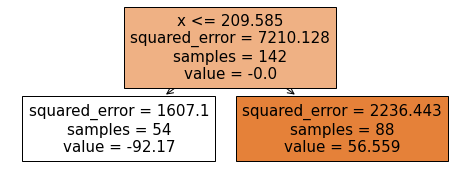

In [17]:
fig = plt.figure(figsize=(8,3))
_ = tree.plot_tree(dt,
                   feature_names=['x'],
                   filled=True)

Já que estamos tentando criar um modelo para prever o resíduo, vamos olhar o quão bem ele performa através do gráfico de resíduos de $F_{0}(x)$

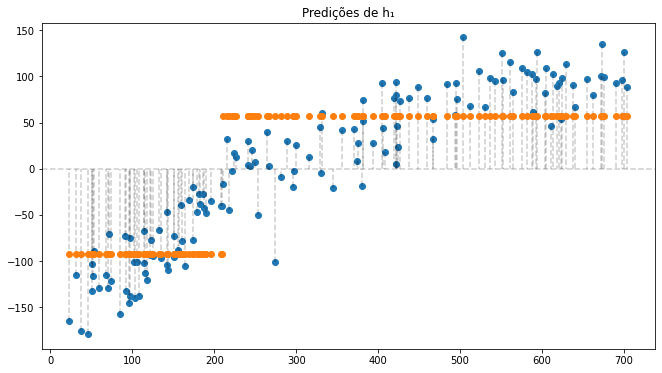

In [19]:
f, ax = plt.subplots(1,1,figsize=(11,6),sharex=True)

media = df.y.mean()

residuos = [y-media for y in df.y]

ax.scatter(df.x,residuos) ## dispersão dos resíduos
ax.scatter(df.x,df.h1_pred,c='tab:orange',zorder=100)
ax.axhline(0,c='black',ls='--',alpha=0.2) ## linha zero
ax.vlines(df.x,residuos,0,color='black',ls='--',alpha=0.2) ## linhas resíduos
ax.set_title('Predições de h{}'.format(get_sub('1')));

O resultado acima é facilmente interpretado quando conhecemos a lógica por trás de um árvore de decisão de regressão. O intuito agora é somar os resultados do modelo $F_{0}$ aos resultados do modelo $h_{1}$ gerando:

$F_{1}(x) = F_{0}(x) + h_{1}(x)$

Será que o resultado fica bom? Vamos testar ...

In [21]:
df['f1_pred'] = df.f0_pred + df.h1_pred
df['f1_res'] = df.y - df.f1_pred
df.head()

,x,y,f0_pred,f0_res,h1_pred,f1_pred,f1_res
0,84.40,36.82,193.865211,-157.045211,-92.169841,101.69537,-64.87537
1,36.75,18.46,193.865211,-175.405211,-92.169841,101.69537,-83.23537
2,23.25,29.44,193.865211,-164.425211,-92.169841,101.69537,-72.25537
3,45.29,15.09,193.865211,-178.775211,-92.169841,101.69537,-86.60537
4,95.85,49.05,193.865211,-144.815211,-92.169841,101.69537,-52.64537


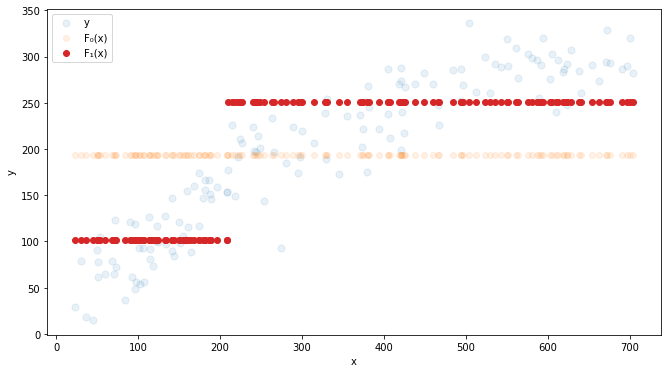

In [22]:
f, ax = plt.subplots(1,1,figsize=(11,6),sharex=True)
df.plot.scatter(x='x',y='y',ax=ax,s=50,label='y',alpha=0.1)
ax.scatter(df.x,[df.y.mean() for _ in range(len(df.x))],c='tab:orange',label='F{}(x)'.format(get_sub('0')),alpha=0.1)
ax.scatter(df.x,df.f1_pred,c='tab:red',label='F{}(x)'.format(get_sub('1')))
plt.legend();

Será que, em termos de R<sup>2</sup>, esse novo modelo é melhor?

In [23]:
r2_score(df.y,df.f1_pred)

0.7230124965305971

Pelo resultado acima vemos que sim, o modelo $F_{1}$ é melhor que $F_{0}$. Não vamos parar por aqui não! Vamos continuar e já temos um passo-a-passo na cabeça:

1. Criar o modelo complementar $h_{2}$
2. Treinar o model complementar utilizando $y-F_{1}(x)$ como target
3. Calcular o resultado de $h_{2}(x)$
4. Plugar os valores na função $F_{2}(x) = F_{1}(x) + h_{2}(x)$

Conseguimos fazer isso facilmente ...

In [24]:
## passo 1 e 2
dt2 = DecisionTreeRegressor(max_depth=1,random_state=42).fit(df.x.values.reshape(-1,1),df.f1_res)

## passo 3
df['h2_pred'] = dt2.predict(df.x.to_numpy().reshape(-1,1))
df.head()

,x,y,f0_pred,f0_res,h1_pred,f1_pred,f1_res,h2_pred
0,84.40,36.82,193.865211,-157.045211,-92.169841,101.69537,-64.87537,-16.358615
1,36.75,18.46,193.865211,-175.405211,-92.169841,101.69537,-83.23537,-16.358615
2,23.25,29.44,193.865211,-164.425211,-92.169841,101.69537,-72.25537,-16.358615
3,45.29,15.09,193.865211,-178.775211,-92.169841,101.69537,-86.60537,-16.358615
4,95.85,49.05,193.865211,-144.815211,-92.169841,101.69537,-52.64537,-16.358615


In [25]:
## passo 4

df['f2_pred'] = df.f1_pred + df.h2_pred
df['f2_res'] = df.y - df.f2_pred
df.head()

,x,y,f0_pred,f0_res,h1_pred,f1_pred,f1_res,h2_pred,f2_pred,f2_res
0,84.40,36.82,193.865211,-157.045211,-92.169841,101.69537,-64.87537,-16.358615,85.336755,-48.516755
1,36.75,18.46,193.865211,-175.405211,-92.169841,101.69537,-83.23537,-16.358615,85.336755,-66.876755
2,23.25,29.44,193.865211,-164.425211,-92.169841,101.69537,-72.25537,-16.358615,85.336755,-55.896755
3,45.29,15.09,193.865211,-178.775211,-92.169841,101.69537,-86.60537,-16.358615,85.336755,-70.246755
4,95.85,49.05,193.865211,-144.815211,-92.169841,101.69537,-52.64537,-16.358615,85.336755,-36.286755


Olhando o dataframe acima, parece que o resíduo está cada vez mais baixo, vamos analisar com um gráfico ...

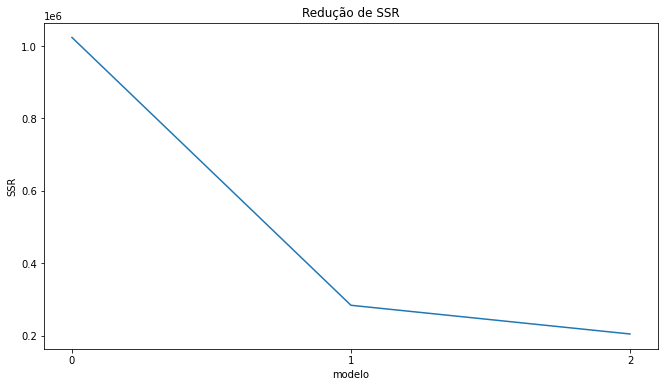

In [26]:
f, ax = plt.subplots(1,1,figsize=(11,6),sharex=True)

## quantidade de modelos
n_models = 3

## calculando ssr (sum of squared residuals)

ssr_models = [sum(df[f'f{x}_res']**2) for x in range(n_models)]

ax.plot(range(n_models),ssr_models)
ax.set_xticks(range(n_models))
ax.set_xlabel('modelo')
ax.set_ylabel('SSR')
ax.set_title('Redução de SSR')
plt.show()

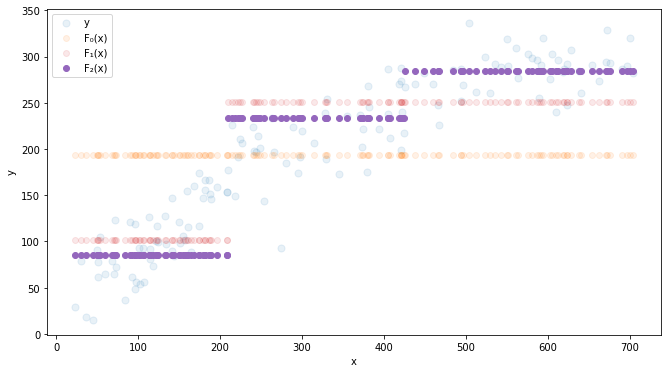

In [18]:
f, ax = plt.subplots(1,1,figsize=(11,6),sharex=True)
df.plot.scatter(x='x',y='y',ax=ax,s=50,label='y',alpha=0.1)
ax.scatter(df.x,[df.y.mean() for _ in range(len(df.x))],c='tab:orange',label='F{}(x)'.format(get_sub('0')),alpha=0.1)
ax.scatter(df.x,df.f1_pred,c='tab:red',label='F{}(x)'.format(get_sub('1')),alpha=0.1)
ax.scatter(df.x,df.f2_pred,c='tab:purple',label='F{}(x)'.format(get_sub('2')))
plt.legend();

In [27]:
r2_score(df.y,df.f2_pred)

0.8004700022180415

Então podemos dizer, com algum grau de certeza, que aumentar a quantidade de modelos pode contribuir positivamente para o resultado final. Ou seja, vários modelos ruins juntos entregam um resultado melhor do que um modelo sozinho, criamos um algoritmo em ensemble utilizando boosting.

Obs.: a afirmação acima está correta somente no contexto desse tutorial. Em outra oportunidade vamos aprender sobre gradiente descendente e como ele pode nos ajudar a definir se a adição de modelos está de fato reduzindo SSR (nossa loss).

O nosso modelo final dependerá da quantidade $M$ de modelos e será dado pela função ...

$F_{M}(x) = F_{0}(x) + \sum_{m=1}^{M}h_{m}(x)$

## Vamos automatizar ...

In [28]:
## carregando novamente os dados

df = pd.read_csv('../data/regression_data_2.csv',usecols=['x','y'])
df.x = df.x.apply(round,ndigits=2)
df.y = df.y.apply(round,ndigits=2)
df.head()

,x,y
0,84.40,36.82
1,36.75,18.46
2,23.25,29.44
3,45.29,15.09
4,95.85,49.05


In [29]:
M = 8

In [30]:
for model in range(M+1):
    if model == 0:
        ## calculando a predicao de f0
        df[f'f{model}_pred'] = df.y.mean()
        
        ##calculando o residuo de f0
        df[f'f{model}_res'] = df.y - df[f'f{model}_pred']
    else:
        ## o x será sempre o mesmo
        x = df.x.values.reshape(-1,1)
        
        ## o target será sempre model-1
        target = df[f'f{model-1}_res']
        
        ## criando o modelo complementar h_m
        dt = DecisionTreeRegressor(max_depth=1,random_state=42).fit(x,target)
        
        ## criando as predições do modelo complementar h_m
        df[f'h{model}_pred'] = dt.predict(x)
        
        ## criando os residuos do modelo complementar h_m
        df[f'h{model}_res'] = target - df[f'h{model}_pred']
        
        ## definindo as predições do modelo f_m
        df[f'f{model}_pred'] = df[f'f{model-1}_pred'] + df[f'h{model}_pred']
        
        ## definido os resídos da predição do modelo f_m
        df[f'f{model}_res'] = df.y - df[f'f{model}_pred']

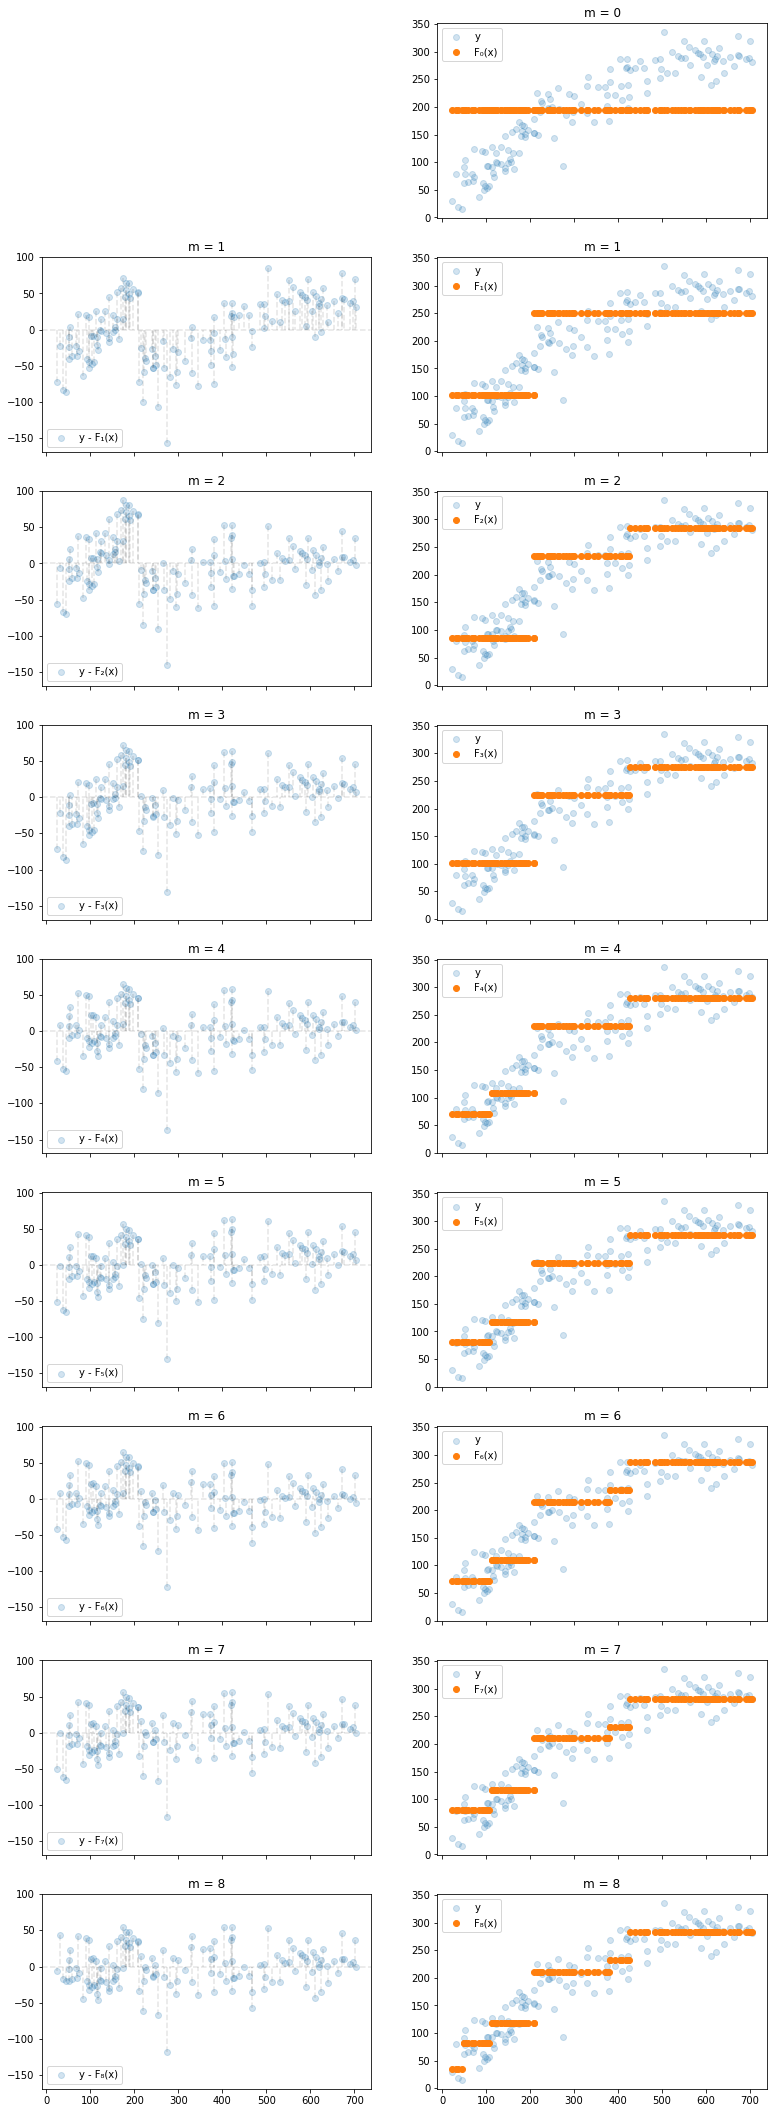

In [31]:
f, ax = plt.subplots(M+1,2,sharex=True,sharey='col',figsize=(13,M+30))

ax[0,0].axis('off')

for i in range(M+1):
    for j in range(2):
        if i == 0 and j == 0:
            pass
        else:
            ## titles
            ax[i,j].set_title(f'm = {i}')
            
            if j == 1:
                ## plot modelos
                ax[i,j].scatter(df.x,df.y,label='y',alpha=0.2,color='tab:blue')
                ax[i,j].scatter(df.x,df[f'f{i}_pred'],color='tab:orange',label=f'F{get_sub(str(i))}(x)')
                ax[i,j].legend(loc=2)
            else:
                ## plot residuos
                ax[i,j].scatter(df.x,df[f'f{i}_res'],alpha=0.2,label=f'y - F{get_sub(str(i))}(x)')
                ax[i,j].axhline(0,c='black',ls='--',alpha=0.1) ## linha zero
                ax[i,j].vlines(df.x,df[f'f{i}_res'],0,color='black',ls='--',alpha=0.1) ## linhas resíduos
                ax[i,j].legend(loc=3)
                


In [33]:
df.head()

,x,y,f0_pred,f0_res,h1_pred,h1_res,f1_pred,f1_res,h2_pred,h2_res,...,f6_pred,f6_res,h7_pred,h7_res,f7_pred,f7_res,h8_pred,h8_res,f8_pred,f8_res
0,84.40,36.82,193.865211,-157.045211,-92.169841,-64.87537,101.69537,-64.87537,-16.358615,-48.516755,...,71.652873,-34.832873,8.719805,-43.552678,80.372678,-43.552678,1.298266,-44.850944,81.670944,-44.850944
1,36.75,18.46,193.865211,-175.405211,-92.169841,-83.23537,101.69537,-83.23537,-16.358615,-66.876755,...,71.652873,-53.192873,8.719805,-61.912678,80.372678,-61.912678,-44.790178,-17.122500,35.582500,-17.122500
2,23.25,29.44,193.865211,-164.425211,-92.169841,-72.25537,101.69537,-72.25537,-16.358615,-55.896755,...,71.652873,-42.212873,8.719805,-50.932678,80.372678,-50.932678,-44.790178,-6.142500,35.582500,-6.142500
3,45.29,15.09,193.865211,-178.775211,-92.169841,-86.60537,101.69537,-86.60537,-16.358615,-70.246755,...,71.652873,-56.562873,8.719805,-65.282678,80.372678,-65.282678,-44.790178,-20.492500,35.582500,-20.492500
4,95.85,49.05,193.865211,-144.815211,-92.169841,-52.64537,101.69537,-52.64537,-16.358615,-36.286755,...,71.652873,-22.602873,8.719805,-31.322678,80.372678,-31.322678,1.298266,-32.620944,81.670944,-32.620944


In [46]:
df.y - (df.f0_pred + df[[f'h{i}_pred' for i in range(1,9)]].sum(axis=1))

0     -44.850944
1     -17.122500
2      -6.142500
3     -20.492500
4     -32.620944
         ...    
137    -9.080944
138   -24.980944
139    -3.830944
140   -20.160944
141    -2.450944
Length: 142, dtype: float64

## Indo além ...

Se continuarmos adicionando modelos ao nosso algoritmo vamos chegar uma situação onde nossos resíduos estarão próximos a zero, ou seja, para esse conjunto de dados nosso modelo final errará praticamente nada. Essa é uma situação clara de overfitting, podemos resolver adicionando um fator de aprendizagem ao modelo para sua regularização.

$F_{M}(x) = F_{0}(x) + \eta \sum_{m=1}^{M}h_{m}(x)$

Esse fator é chamado de *learning rate*. Vamos aprender mais sobre ele quando formos falar sobre redes neurais. Ele normalmente descreve valores entre 0 e 1.

In [24]:
['f0_pred'] + [x for x in df.columns if x.startswith('h') and x.endswith('pred')]

['f0_pred',
 'h1_pred',
 'h2_pred',
 'h3_pred',
 'h4_pred',
 'h5_pred',
 'h6_pred',
 'h7_pred',
 'h8_pred']

In [25]:
df[['f0_pred'] + [x for x in df.columns if x.startswith('h') and x.endswith('pred')]]

,f0_pred,h1_pred,h2_pred,h3_pred,h4_pred,h5_pred,h6_pred,h7_pred,h8_pred
0,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,1.298266
1,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,-44.790178
2,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,-44.790178
3,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,-44.790178
4,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,1.298266
...,...,...,...,...,...,...,...,...,...
137,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,1.298266
138,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,1.298266
139,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,1.298266
140,193.865211,-92.169841,-16.358615,16.358615,-31.126675,9.803982,-8.719805,8.719805,1.298266


In [47]:
## resultado sem learning_rate


y_pred_s_lr = df['f0_pred'] + (df[[x for x in df.columns if x.startswith('h') and x.endswith('pred')]].sum(axis=1))
r2_score(df.y,y_pred_s_lr)

0.8872064535040651

In [50]:
## resultado com learning_rate

lr = 0.8

y_pred_c_lr = df['f0_pred'] + (df[[x for x in df.columns if x.startswith('h') and x.endswith('pred')]]*lr).sum(axis=1)
r2_score(df.y,y_pred_c_lr)

0.8515650178876643

O que acontece com os valores preditos quando modificamos nosso *learning rate*?

## Finalizando

In [54]:
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
lr = 0.98
n_trees = 500
max_depth = 1

x = df.x.values.reshape(-1,1)
y = df.y

F0 = df.y.mean()
Fm = F0

trees = []

for _ in range(n_trees):
    tree = DecisionTreeRegressor(max_depth=max_depth,random_state=42)
    tree.fit(x,y-Fm)
    Fm += lr* tree.predict(x)
    trees.append(tree)
    
y_pred = F0 + lr * np.sum([t.predict(x) for t in trees],axis=0)

In [69]:
y_pred

array([ 62.59814939,  21.39894567,  29.5031023 ,  21.39894567,
        68.68825231,  76.32325969,  72.98739645,  74.95498986,
        87.48221869,  74.88792558,  77.85027103,  72.70206095,
       108.20771606,  72.70206095,  91.48073209,  99.58630971,
       100.39131692,  76.32325969,  72.70206095, 106.09363231,
       106.09363231, 152.09385593, 108.75770382, 154.50642416,
       116.18769641, 152.09385593, 120.13129027, 154.50642416,
       154.50642416, 202.42214395, 183.67009208, 154.50642416,
       154.50642416, 152.09385593, 152.09385593, 152.09385593,
       202.42214395, 200.34186787, 201.27961483, 202.42214395,
       191.19923217, 195.51841444, 202.42214395, 195.51841444,
       214.34620545, 198.83319201, 217.45383034, 218.71295898,
       214.34620545, 243.02303233, 250.81525058, 220.97793491,
       245.27326742, 245.27326742, 243.02303233, 220.97793491,
       272.10603457, 253.70353085, 265.4107444 , 269.36578565,
       253.70353085, 278.82475078, 284.74146479, 284.74

In [62]:
model = GradientBoostingRegressor(n_estimators=500,
                                  learning_rate=lr,
                                  max_depth=max_depth,
                                  random_state=42,
                                  validation_fraction=0)
model.fit(x,y)

y_pred_model = model.predict(x)

In [63]:
y_pred_model

array([ 62.59814939,  21.39894567,  29.5031023 ,  21.39894567,
        68.68825231,  76.32325969,  72.98739645,  74.95498986,
        87.48221869,  74.88792558,  77.85027103,  72.70206095,
       108.20771606,  72.70206095,  91.48073209,  99.58630971,
       100.39131692,  76.32325969,  72.70206095, 106.09363231,
       106.09363231, 152.09385593, 108.75770382, 154.50642416,
       116.18769641, 152.09385593, 120.13129027, 154.50642416,
       154.50642416, 202.42214395, 183.67009208, 154.50642416,
       154.50642416, 152.09385593, 152.09385593, 152.09385593,
       202.42214395, 200.34186787, 201.27961483, 202.42214395,
       191.19923217, 195.51841444, 202.42214395, 195.51841444,
       214.34620545, 198.83319201, 217.45383034, 218.71295898,
       214.34620545, 243.02303233, 250.81525058, 220.97793491,
       245.27326742, 245.27326742, 243.02303233, 220.97793491,
       272.10603457, 253.70353085, 265.4107444 , 269.36578565,
       253.70353085, 278.82475078, 284.74146479, 284.74

In [42]:
y_pred

array([ 82.11103554,  36.48736724,  36.48736724,  36.48736724,
        82.11103554,  82.11103554,  36.48736724,  82.11103554,
        82.11103554,  82.11103554,  82.11103554,  82.11103554,
       118.16667841,  82.11103554, 118.16667841,  82.11103554,
       118.16667841,  82.11103554,  82.11103554, 118.16667841,
       118.16667841, 118.16667841, 118.16667841, 118.16667841,
       118.16667841, 118.16667841, 118.16667841, 118.16667841,
       118.16667841, 211.61618482, 211.61618482, 118.16667841,
       118.16667841, 118.16667841, 118.16667841, 118.16667841,
       211.61618482, 211.61618482, 211.61618482, 211.61618482,
       211.61618482, 211.61618482, 211.61618482, 211.61618482,
       211.61618482, 211.61618482, 211.61618482, 211.61618482,
       211.61618482, 232.05613269, 232.05613269, 232.05613269,
       232.05613269, 232.05613269, 232.05613269, 232.05613269,
       283.18423235, 283.18423235, 232.05613269, 283.18423235,
       283.18423235, 283.18423235, 283.18423235, 283.18